In [5]:
import numpy as np
import pandas as pd


In [6]:
def ThermalConductivity(Water, Mineral, Organic):
    
    #thermal conductivty estimated according to 
    ka = 0.025;       #air [Hillel(1982)]
    kw = 0.57;        #water [Hillel(1982)]
    ko = 0.25;        #organic [Hillel(1982)]
    km = 3.8;         #mineral [Hillel(1982)]
    ki = 2.2;         #ice [Hillel(1982)]

    air = 1.0 - Water - Mineral - Organic
    TC = (Water * kw**0.5 + Mineral * km**0.5 + Organic * ko**0.5 + air * ka**0.5)**2.0
    return TC

In [7]:
def ThawDepth(Tav,Theta_w, Theta_m, Theta_o):
    L_sl = 334.0e3 #J/kg laten heat of fusion
    rho_w = 1.0e3 #[kg/m³] denstiy of water
    dt = 86400 #[s] seconds per day
    
    J = np.cumsum(Tav*(Tav>0.0)) * dt #[Ks] integrated thawing degree days 
    TC_t = ThermalConductivity(Theta_w, Theta_m, Theta_o) #[W/mK] thermal conductivity
        
    d = ((2. * TC_t)/(rho_w * L_sl * Theta_w) * np.abs(J))**0.5 #[m] thaw depth
    
    T_f = 0. #[°C]
    
    G = TC_t * (Tav - T_f) / d * dt / 1e6 #[MJ/day] ground heat flux per day
    G[np.isinf(G)] = 0.0 #set inf to zero if d == 0
    G[np.isnan(G)] = 0.0 #set nan to zero if d and Tav == 0
    
    return d, G

/tmp/ipykernel_363006/51589329.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean()


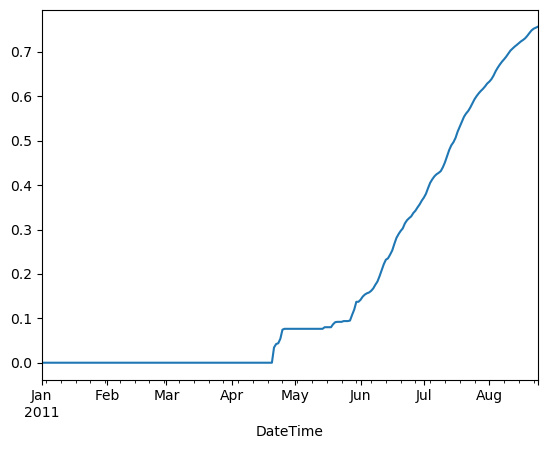

In [8]:
#load meteorological observations
file = 'data/Samoylov_2002-2011_meteorology.tab'
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])

dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-8-25'] 

df_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean() 
meteorology_mean = df_mean   

T_av = meteorology_mean['T2 [°C]'] 

Theta_w = 0.5
Theta_m = 0.2
Theta_o = 0.05

[thaw_depth, G] = ThawDepth(T_av,Theta_w, Theta_m, Theta_o)
thaw_depth.plot()